MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

Build Super-resolution DEM 0.5m from DEM 1m enhanced by one orthophoto image 0.5m

Source dataset: Elevation1 - Mashhad, Iran

Elevation1 DSM + Pléiades Ortho 0.5m pan-sharpened (Orthoimage included)

https://www.intelligence-airbusds.com/en/9317-sample-imagery-detail?product=18896&keyword=&type=366

In [1]:
from osgeo import gdal
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
%matplotlib inline

### Load DEM

In [2]:
# DEM image
dem = xr.open_rasterio("Mashhad-DEM.sample.tif")[0].rename({'x':'lon','y':'lat'})
# invert latitude axis
dem.values = dem.values[::-1]
dem.lat.values = dem.lat.values[::-1]
del dem.attrs['units']

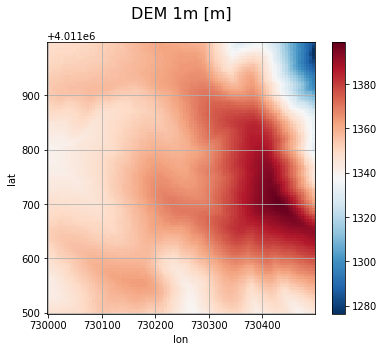

In [3]:
plt.figure(figsize=(6,5))
dem[::5,::5].plot(cmap='RdBu_r')
plt.grid()
plt.title("DEM 1m [m]\n", fontsize=16)
plt.show()

### Load orthophoto image

In [4]:
# orthophoto image 0.5m for the same area as DEM data above
img = xr.open_rasterio("7289-40126_Mashhad.sample.tif")[0].rename({'x':'lon','y':'lat'})
# invert latitude axis
img.values = img.values[::-1]
img.lat.values = img.lat.values[::-1]

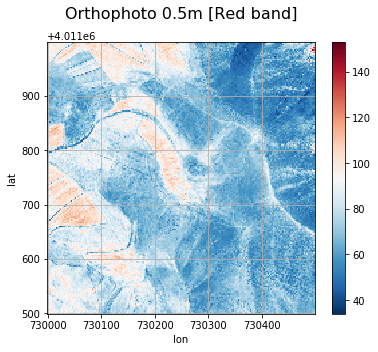

In [5]:
plt.figure(figsize=(6,5))
img[::5,::5].plot(cmap='RdBu_r')
plt.grid()
plt.title("Orthophoto 0.5m [Red band]\n", fontsize=16)
plt.show()

### Original DEM and orthophoto image

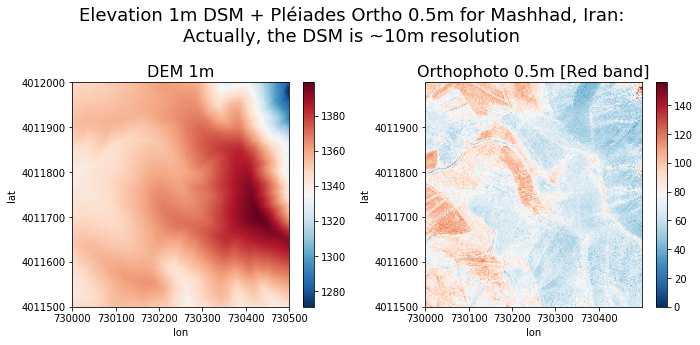

In [30]:
# larger area
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

title = 'Elevation 1m DSM + Pléiades Ortho 0.5m for Mashhad, Iran:\nActually, the DSM is ~10m resolution'

dem.plot(cmap='RdBu_r',ax=ax1)
ax1.set_title('DEM 1m', fontsize=16)
img[::2,::2].plot(vmin=0,cmap='RdBu_r',ax=ax2)
ax2.set_title('Orthophoto 0.5m [Red band]', fontsize=16)

ax2.ticklabel_format(useOffset=False)

plt.suptitle(title, fontsize=18)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.85])
plt.savefig(title.replace(':','.').replace('\n',' ') + '.jpg', dpi=150)
plt.show()

### Regrid DEM 1m on the same grid as orthophoto image 0.5m
This is nearest neighbor interpolation without any data quality enhancement

In [7]:
# define source values
df_dem = dem.to_dataframe(name='dem').dropna().reset_index()
# target grid 
df_grid = img.to_dataframe(name='_').reset_index()[['lat','lon']]
# nearest neighbor interpolation
tree = cKDTree(list(zip(df_dem.lon, df_dem.lat)))
distance, indices = tree.query(list(zip(df_grid.lon, df_grid.lat)), k = 1)
values = df_dem.dem.values[indices]
dem2x = xr.DataArray(values.reshape(img.shape),
                          coords=[img.lat,img.lon])

### Enhance DEM by orthophoto image
As explained in the article we need to transfer spatial components 0-5m

With pixel size 0.5m the required filter radius is equal to 10 pixels because 10*0.5m = 5m

In [8]:
# caclulate approximate scale factor for short wavelenghs
scale = (img.max()-img.min())/(dem2x.max()-dem2x.min())

In [9]:
# low-pass filter
def raster_filter(src, gamma):
    dst = src.copy()
    dst.values = gaussian_filter(dst.values.astype(np.float32),gamma,mode='nearest')
    return dst

# define spectrum components to transfer
radius = 5/img.res[0]

img_lowpass = raster_filter(img, radius)
img_hipass  = img - img_lowpass

dem2x_lowpass = raster_filter(dem2x, radius)
dem2x_hipass  = dem2x - dem2x_lowpass

# super-resolution dataset
dem2x_hires = dem2x_lowpass + img_hipass/scale

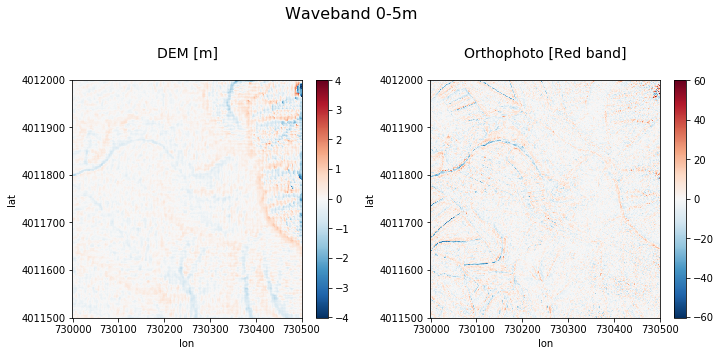

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

dem2x_hipass[::3,::3].plot(cmap='RdBu_r',ax=ax1)
ax1.set_title('DEM [m]\n', fontsize=14)
img_hipass[::3,::3].plot(cmap='RdBu_r',ax=ax2)
ax2.set_title('Orthophoto [Red band]\n', fontsize=14)

plt.suptitle('Waveband 0-5m', fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.show()

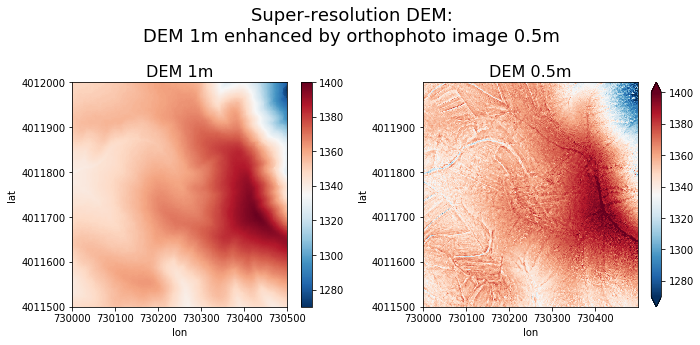

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

title = 'Super-resolution DEM:\nDEM 1m enhanced by orthophoto image 0.5m'

dem2x.plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax1)
ax1.set_title('DEM 1m', fontsize=16)
dem2x_hires[::2,::2].plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax2)
ax2.set_title('DEM 0.5m', fontsize=16)

ax2.ticklabel_format(useOffset=False)

plt.suptitle(title, fontsize=18)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.85])
plt.savefig(title.replace(':','.').replace('\n',' ') + '.jpg', dpi=150)
plt.show()

In [12]:
# compare original and target DEM
float((dem2x_hires-dem2x).mean()),float((dem2x_hires-dem2x).std())

(-0.00850087683647871, 5.423844814300537)